In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from collections import defaultdict
import io
from tqdm.auto import tqdm

from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from torchvision.transforms import v2 as transforms_v2
from pytorch_msssim import ssim, ms_ssim
import compressai

from Iwildcam_Pretrain import Autoencoder, Encoder, Decoder, IWildCamDataset, CompressaiWrapper
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
[rank: 0] Seed set to 42


Device: cuda:0


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "best_checkpoints_hyperprior/"
# HEIGHT = 96
# WIDTH = 160
HEIGHT = 96 * 2
WIDTH = 160 * 2
PRECISION = 32
DO_CACHING = False
# DATASET_ROOT = "/data/vision/beery/scratch/data/iwildcam_unzipped"
DATASET_ROOT = "/tmp/iwildcam_unzipped"

Device: cuda:0


In [4]:
def get_lora_model(
        latent_dim,
        lora_precision=None,
        loraize_encoder = False,  # no reason really to do this unless we want to reduce memory footprint
        loraize_decoder = True,
        finetune = True,
        model_type = 'hyperprior',
):
    if finetune and lora_precision == 32:
        lora_precision = None

    lora_config = {
        torch.nn.Conv2d: {
            'cls': LoRAConv2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.Linear: {
            'cls': LoRALinear,
            'config': {
                'rank': 4,
                'alpha': 2,
                'delta_bias':  False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.ConvTranspose2d: {
            'cls': LoRAConvTranspose2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        }
    }

    # load two copies so we can lora-ize one
    if model_type == 'vanilla':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model for latent dim {latent_dim}, loading...")
            _model = Autoencoder.load_from_checkpoint(pretrained_filename)
            model  = Autoencoder.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    elif model_type == 'hyperprior':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"bmshj2018_hyperprior-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model, loading...")
            model  = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
            _model = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    else:
        raise ValueError('Invalid model_type')
    
    if not finetune:
        return model
    
    if model_type == 'vanilla':
        if loraize_encoder:
            for i, module in enumerate(_model.encoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

        if loraize_decoder:
            for i, module in enumerate(_model.decoder.linear.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

            for i, module in enumerate(_model.decoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)
    
    elif model_type == 'hyperprior':
            # freeze decoder stuff that won't be transmitted
        print("Freezing:")
        for name, param in model.model.g_s.named_parameters():
            print(name)
            param.requires_grad = False
        for name, param in model.model.h_s.named_parameters():
            print(name)
            param.requires_grad = False

        print("Fine-tuning:")
        for i, module in enumerate(_model.model.g_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.model.h_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.h_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.h_s[i].enable_adapter()                # but we need to turn on the adapter path
    else:
        raise ValueError('Invalid model_type')

    del _model # get rid of the clone
    return model

In [5]:
def compute_bits_per_pixel(model, latent_dim, lora_precision, width, height):
    param_size = 0
    for name, param in model.named_parameters():
        if "delta" in name:
            param_size += param.nelement() * (lora_precision / 8)

    # assume we don't have to transmit these if they are fixed -- this would be alpha, rank hyperparams
    buffer_size = 0

    latent_size = latent_dim * 4  # TODO: this is for full precision models, handle quantized models as well


    param_bpp = 8 * (param_size + buffer_size) / (width * height)
    latent_bpp = 8 * latent_size / (width * height)

    return param_bpp, latent_bpp

In [6]:
our_test_set_ids = [292, 181, 430, 20, 4]
latent_dim = 256

results = []

for lora_precision in [0, 4, 8, 32]:
    finetune = lora_precision is not None

    for loc_id in our_test_set_ids:
        test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
        if DO_CACHING:
            test_set.cache_on_device_(device)
            test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
        test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

        model = get_lora_model(latent_dim, lora_precision, finetune=finetune)
        # print(model)
        # for n, p in model.named_parameters():
        #     print(f"{n}: {p.requires_grad}")
        
        # Freeze decoder if specified
        # TODO remove this once lora-ize decoder works
        # freeze_decoder = True
        # if freeze_decoder:
        # for param in model.decoder.parameters():
        #     param.requires_grad = False
        # print(f"Decoder frozen for location {loc_id}")

        trainer = pl.Trainer(
            default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
            accelerator="gpu" if str(device).startswith("cuda") else "cpu",
            precision=PRECISION,
            devices=1,
            max_epochs=1,
            callbacks=[
                ModelCheckpoint(save_weights_only=True),
                LearningRateMonitor("epoch")
            ]
        )

        # Train the model
        # Overfit to the test set
        if finetune:
            trainer.fit(model, test_loader, test_loader)
            save_path = os.path.join(CHECKPOINT_PATH, f"iwildcam_latent_dim={latent_dim}_lora_loc={loc_id}.ckpt")
            trainer.save_checkpoint(save_path)

        test_metrics = trainer.test(model=model, dataloaders=test_loader)[0]

        # test_reconstruction_error = test_results[0]['test_loss']
        # test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches? Timm: docs say default aggregation is torch.mean

        param_bpp, latent_bpp = compute_bits_per_pixel(model, latent_dim, lora_precision, WIDTH, HEIGHT)

        # Store results
        results.append(dict(
            finetuned=finetune,
            lora_precision=lora_precision,
            param_bpp=param_bpp,
            latent_bpp=latent_bpp,
            loc_id=loc_id,
            n_images=len(test_set.data['images']),
            **test_metrics,
        ))

        # release memory
        del test_set
        del model
        del trainer
        torch.cuda.empty_cache()

    # # Step 6: Visualize the results
    # # Bar chart of reconstruction error by location
    # locations, num_images, errors = zip(*results)

    # # Bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(locations, errors, color='skyblue', edgecolor='black')
    # plt.xlabel("Location ID", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Reconstruction Error by Location", fontsize=14)
    # plt.grid(True)
    # plt.show()

    # # Scatter plot of number of images vs. reconstruction error
    # plt.figure(figsize=(10, 6))
    # plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
    # plt.xlabel("Number of Images", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
    # plt.grid(True)
    # plt.show()

Found pretrained model, loading...


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/vision/beery/scratch/timm/micromamba/envs/aeco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-of

Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))



  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:12<00:00,  0.25it/s, v_num=7, train_loss_step=0.00684, val_loss_step=0.00429, val_loss_epoch=0.00451, train_loss_epoch=0.00649]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:12<00:00,  0.25it/s, v_num=7, train_loss_step=0.00684, val_loss_step=0.00429, val_loss_epoch=0.00451, train_loss_epoch=0.00649]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.004514965694397688
      test_ms_ssim          0.9174917340278625
        test_ssim           0.6973665952682495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.33it/s, v_num=4, train_loss_step=0.000448, val_loss_step=0.00799, val_loss_epoch=0.00799, train_loss_epoch=0.000448]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, v_num=4, train_loss_step=0.000448, val_loss_step=0.00799, val_loss_epoch=0.00799, train_loss_epoch=0.000448]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.007985319010913372
      test_ms_ssim          0.9188433289527893
        test_ssim           0.7461961507797241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 20/20 [00:24<00:00,  0.80it/s, v_num=4, train_loss_step=0.00144, val_loss_step=0.0013, val_loss_epoch=0.0013, train_loss_epoch=0.00433]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:25<00:00,  0.80it/s, v_num=4, train_loss_step=0.00144, val_loss_step=0.0013, val_loss_epoch=0.0013, train_loss_epoch=0.00433]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0012973499251529574
      test_ms_ssim          0.9459400773048401
        test_ssim           0.7969580292701721
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.89it/s, v_num=4, train_loss_step=0.00187, val_loss_step=0.00188, val_loss_epoch=0.00218, train_loss_epoch=0.00452]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.89it/s, v_num=4, train_loss_step=0.00187, val_loss_step=0.00188, val_loss_epoch=0.00218, train_loss_epoch=0.00452]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0021775811910629272
      test_ms_ssim          0.9628207087516785
        test_ssim            0.839600682258606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=4, train_loss_step=0.000443, val_loss_step=0.0218, val_loss_epoch=0.0218, train_loss_epoch=0.000443]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=4, train_loss_step=0.000443, val_loss_step=0.0218, val_loss_epoch=0.0218, train_loss_epoch=0.000443]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.021758809685707092
      test_ms_ssim          0.9443117380142212
        test_ssim            0.603368878364563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:12<00:00,  0.25it/s, v_num=8, train_loss_step=0.00801, val_loss_step=0.00386, val_loss_epoch=0.00398, train_loss_epoch=0.00605]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=8, train_loss_step=0.00801, val_loss_step=0.00386, val_loss_epoch=0.00398, train_loss_epoch=0.00605]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.003981611225754023
      test_ms_ssim          0.9189932942390442
        test_ssim           0.7033937573432922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.30it/s, v_num=5, train_loss_step=0.00044, val_loss_step=0.016, val_loss_epoch=0.016, train_loss_epoch=0.00044]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.28it/s, v_num=5, train_loss_step=0.00044, val_loss_step=0.016, val_loss_epoch=0.016, train_loss_epoch=0.00044]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.01603749394416809
      test_ms_ssim          0.9338389039039612
        test_ssim           0.7590070962905884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:25<00:00,  0.78it/s, v_num=5, train_loss_step=0.00148, val_loss_step=0.00137, val_loss_epoch=0.00136, train_loss_epoch=0.00438]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:25<00:00,  0.77it/s, v_num=5, train_loss_step=0.00148, val_loss_step=0.00137, val_loss_epoch=0.00136, train_loss_epoch=0.00438]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0013631003675982356
      test_ms_ssim          0.9430169463157654
        test_ssim            0.788731038570404
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.87it/s, v_num=5, train_loss_step=0.00187, val_loss_step=0.00187, val_loss_epoch=0.00217, train_loss_epoch=0.0046]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.86it/s, v_num=5, train_loss_step=0.00187, val_loss_step=0.00187, val_loss_epoch=0.00217, train_loss_epoch=0.0046]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0021660118363797665
      test_ms_ssim          0.9621384739875793
        test_ssim           0.8339285850524902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=5, train_loss_st

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=5, train_loss_step=0.000443, val_loss_step=0.0217, val_loss_epoch=0.0217, train_loss_epoch=0.000443]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.021695777773857117
      test_ms_ssim          0.9459444284439087
        test_ssim           0.6069311499595642
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:14<00:00,  0.21it/s, v_num=9, train_loss_step=0.00582, val_loss_step=0.00428, val_loss_epoch=0.00452, train_loss_epoch=0.00749]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:14<00:00,  0.20it/s, v_num=9, train_loss_step=0.00582, val_loss_step=0.00428, val_loss_epoch=0.00452, train_loss_epoch=0.00749]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.004521864932030439
      test_ms_ssim          0.9205957651138306
        test_ssim           0.7042944431304932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=6, train_loss_step=0.000446, val_loss_step=0.0134, val_loss_epoch=0.0134, train_loss_epoch=0.000446]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, v_num=6, train_loss_step=0.000446, val_loss_step=0.0134, val_loss_epoch=0.0134, train_loss_epoch=0.000446]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.013422973453998566
      test_ms_ssim          0.9247492551803589
        test_ssim           0.7408847808837891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:25<00:00,  0.79it/s, v_num=6, train_loss_step=0.00154, val_loss_step=0.0014, val_loss_epoch=0.00139, train_loss_epoch=0.00444]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:25<00:00,  0.78it/s, v_num=6, train_loss_step=0.00154, val_loss_step=0.0014, val_loss_epoch=0.00139, train_loss_epoch=0.00444]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0013878021854907274
      test_ms_ssim          0.9423525333404541
        test_ssim           0.7851932644844055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.87it/s, v_num=6, train_loss_step=0.00206, val_loss_step=0.00196, val_loss_epoch=0.00228, train_loss_epoch=0.00467]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:19<00:00,  0.87it/s, v_num=6, train_loss_step=0.00206, val_loss_step=0.00196, val_loss_epoch=0.00228, train_loss_epoch=0.00467]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.002284084912389517
      test_ms_ssim          0.9540945887565613
        test_ssim            0.812240719795227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=6, train_loss_step=0.000444, val_loss_step=0.0223, val_loss_epoch=0.0223, train_loss_epoch=0.000444]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=6, train_loss_step=0.000444, val_loss_step=0.0223, val_loss_epoch=0.0223, train_loss_epoch=0.000444]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.022348085418343544
      test_ms_ssim          0.9460630416870117
        test_ssim           0.6044544577598572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:11<00:00,  0.26it/s, v_num=10, train_loss_step=0.00382, val_loss_step=0.012, val_loss_epoch=0.0104, train_loss_epoch=0.021]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:11<00:00,  0.26it/s, v_num=10, train_loss_step=0.00382, val_loss_step=0.012, val_loss_epoch=0.0104, train_loss_epoch=0.021]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.010429680347442627
      test_ms_ssim          0.8569989204406738
        test_ssim            0.612804114818573
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.35it/s, v_num=7, train_loss_step=0.000489, val_loss_step=0.00631, val_loss_epoch=0.00631, train_loss_epoch=0.000489]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.33it/s, v_num=7, train_loss_step=0.000489, val_loss_step=0.00631, val_loss_epoch=0.00631, train_loss_epoch=0.000489]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.006307336501777172
      test_ms_ssim          0.8912403583526611
        test_ssim           0.7224273085594177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:27<00:00,  0.73it/s, v_num=7, train_loss_step=0.0025, val_loss_step=0.00249, val_loss_epoch=0.00247, train_loss_epoch=0.00684]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:27<00:00,  0.73it/s, v_num=7, train_loss_step=0.0025, val_loss_step=0.00249, val_loss_epoch=0.00247, train_loss_epoch=0.00684]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.002466147765517235
      test_ms_ssim          0.9142006635665894
        test_ssim           0.7360098958015442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:22<00:00,  0.76it/s, v_num=7, train_loss_step=0.00195, val_loss_step=0.0018, val_loss_epoch=0.00208, train_loss_epoch=0.00422]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:22<00:00,  0.75it/s, v_num=7, train_loss_step=0.00195, val_loss_step=0.0018, val_loss_epoch=0.00208, train_loss_epoch=0.00422]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0020837984047830105
      test_ms_ssim          0.9628349542617798
        test_ssim           0.8363137245178223
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(128, 128, kernel_size=(5, 5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------
0 | model | ScaleHyperprior | 5.2 M  | train | [2, 3, 320, 192] | ?        
---------------------------------------------------------------------------------
2.7 M     Trainable params
2.5 M     Non-trainable params
5.2 M     Total params
20.939    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=7, train_loss_step=0.000526, val_loss_step=0.0159, val_loss_epoch=0.0159, train_loss_epoch=0.000526]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=7, train_loss_step=0.000526, val_loss_step=0.0159, val_loss_epoch=0.0159, train_loss_epoch=0.000526]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.015924949198961258
      test_ms_ssim          0.8602345585823059
        test_ssim           0.6987414956092834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
jpeg_results = []
jpeg_sample_size = 100  # TODO: increase

for loc_id in our_test_set_ids:
    test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
    test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
    test_set.data['images'] = np.random.default_rng(seed=42).choice(test_set.data['images'], jpeg_sample_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

    for batch in tqdm(test_loader):
        for el in batch:
            pil_img = Image.fromarray((el.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

            for quality in np.linspace(start=0, stop=100, num=6):

                img_byte_arr = io.BytesIO()
                pil_img.save(img_byte_arr, format='JPEG', quality=int(quality.item()))

                el_bpp = (len(img_byte_arr.getvalue()) * 8) / (el.shape[1] * el.shape[1])

                pil_img = Image.open(img_byte_arr, mode='r')

                el_reconstructed = transforms_v2.ToTensor()(transforms_v2.ToDtype(torch.float32, scale=True)(pil_img))

                el_ssim = ssim(el[None, ...], el_reconstructed[None, ...], 1)
                try:
                    el_ms_ssim = ms_ssim(el[None, ...], el_reconstructed[None, ...], 1)
                except:
                    el_ms_ssim = -1
                jpeg_results.append(dict(quality=quality, bpp=el_bpp, ssim=el_ssim, ms_ssim=el_ms_ssim))

pd.DataFrame(jpeg_results).to_csv("cache/jpeg_results.csv")

  0%|          | 0/1 [00:00<?, ?it/s]/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 1/1 [00:13<00:00, 13.33s/it]


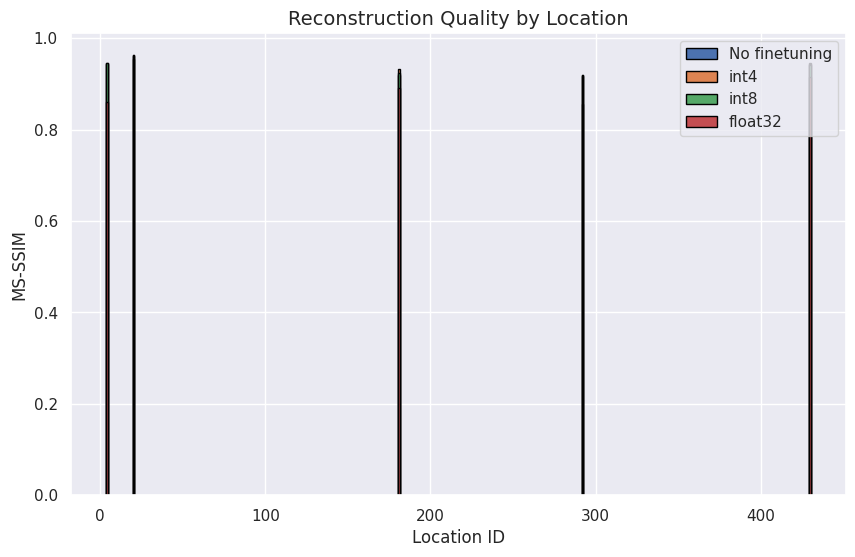

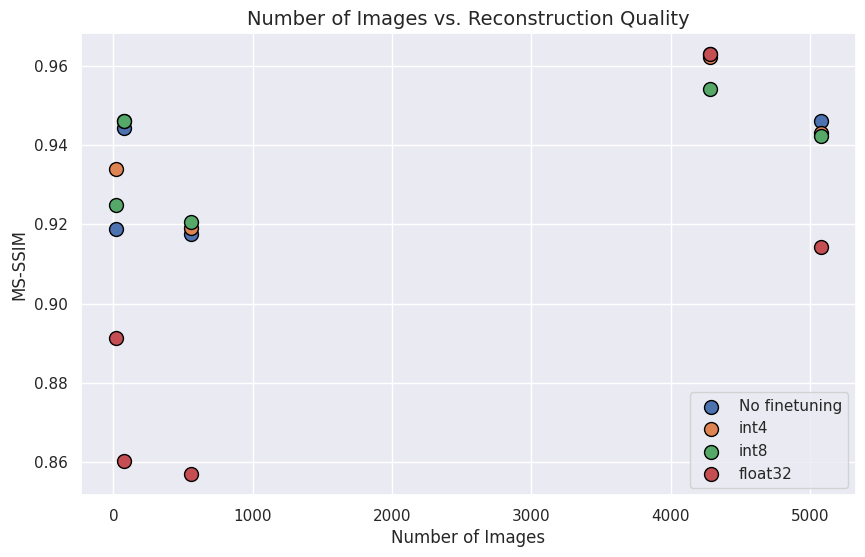

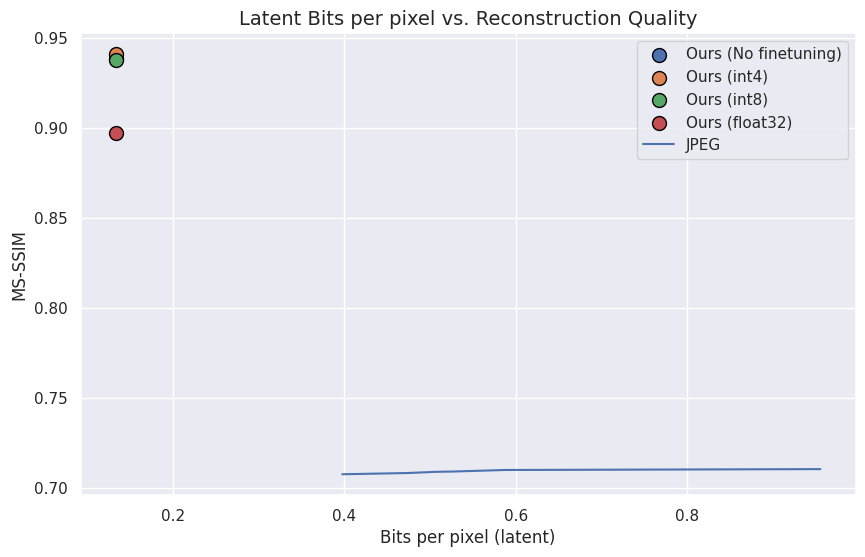

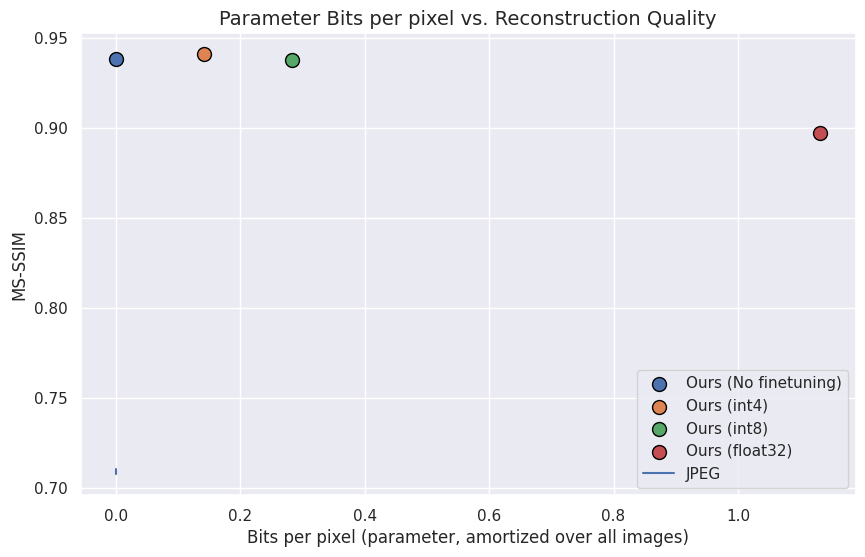

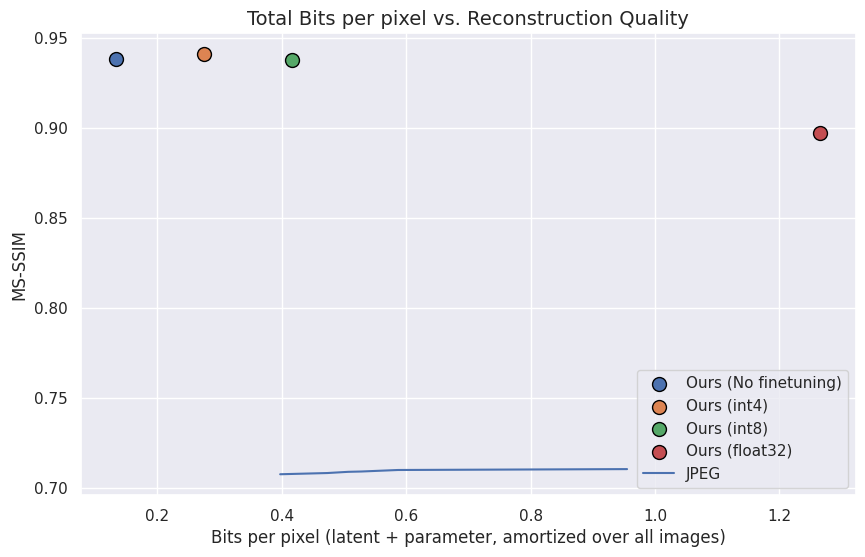

In [16]:
# Step 6: Visualize the results
# Bar chart of reconstruction error by location

lora_precision_labels = dict({ 32: "float32", 8: "int8", 4: "int4", 0: "No finetuning" })

results_df = pd.DataFrame(results)
results_df["lora_precision"] = results_df["lora_precision"].fillna(-1)

jpeg_df = pd.DataFrame(jpeg_results)

# has_mssim = np.isfinite(results_df["test_ms_ssim"]).any() and np.isfinite(jpeg_df["ms_ssim"]).any()
has_mssim = True

# Bar chart
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.bar(results_df[results_df["lora_precision"] == lora_precision]["loc_id"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', label=lora_precision_labels[lora_precision])
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Reconstruction Quality by Location", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["n_images"], results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"], edgecolor='black', s=100, label=lora_precision_labels[lora_precision])
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Number of Images vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Latent Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
jpeg_df_agg = jpeg_df.groupby("quality").mean()
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Latent Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Param Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter((results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(0 * jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Parameter Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Total Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean() + (results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ms_ssim" if has_mssim else "test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.plot(jpeg_df_agg["bpp"], jpeg_df_agg["ms_ssim" if has_mssim else "ssim"], label="JPEG")
plt.xlabel("Bits per pixel (latent + parameter, amortized over all images)", fontsize=12)
plt.ylabel("MS-SSIM" if has_mssim else "SSIM", fontsize=12)
plt.title("Total Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()